# Simple Exploration Notebook - Zillow Prize

이 노트북에서는 Zillow 상금 공모전에 제공된 데이터를 살펴보겠습니다. 데이터를 자세히 살펴보기 전에 대회에 대해 조금 더 알아보겠습니다.

Zillow:

Zestimate는 2006년에 설립된 온라인 부동산 데이터베이스 회사입니다 - Wikipedia

Zestimate:

'Zestimate'는 각 부동산에 대한 수백 개의 데이터 포인트를 분석하는 750만 개의 통계 및 머신 러닝 모델을 기반으로 한 주택 가치 추정치입니다. 또한 오차 중앙값을 지속적으로 개선하여(초기 14%에서 현재 5%로) 오차 중앙값을 개선했습니다,

목표:

제스티메이트의 잔여 오차를 개선하는 모델을 구축하는 것입니다.

공모전은 두 단계로 진행됩니다. 이 공개 대회는 2018년 1월까지 진행되며 총 상금 5만 달러가 걸려 있습니다. 이번 대회에서는 상금이 상당히 다르므로 상금 세부 정보 및 대회 개요를 반드시 읽어보시기 바랍니다.

먼저 필요한 모듈을 가져와 보겠습니다.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

입력 폴더에 있는 파일을 나열해 보겠습니다.              

In [70]:
from subprocess import check_output
print(check_output(["ls", "../input/Zillow Prize: Zillow’s Home Value Prediction"]).decode("utf8"))

properties_2016.csv
sample_submission.csv
train_2016_v2.csv
zillow_data_dictionary.xlsx



먼저 train 파일 탐색부터 시작하겠습니다.

In [71]:
train_df = pd.read_csv("../input/Zillow Prize: Zillow’s Home Value Prediction/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [72]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:**

이 대회의 대상 변수는 "logerror" 필드입니다. 따라서 먼저 이 필드에 대해 몇 가지 분석을 해보겠습니다.

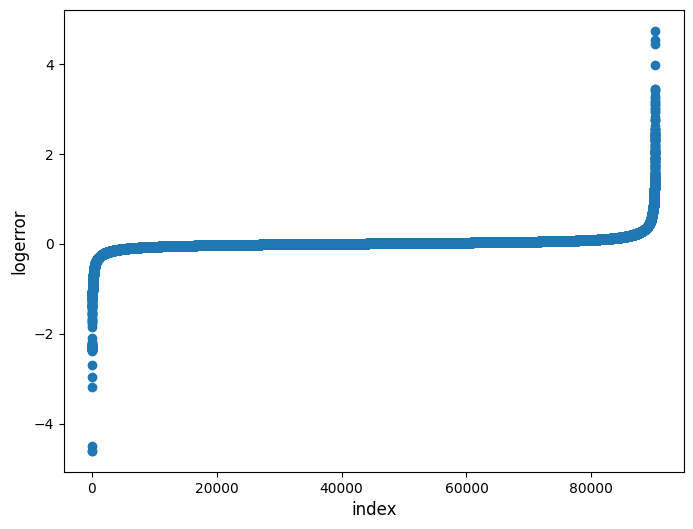

In [73]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

양쪽 끝에 이상값이 있어 멋지게 보입니다.

이상값을 제거한 다음 히스토그램 플롯을 만들어 보겠습니다.

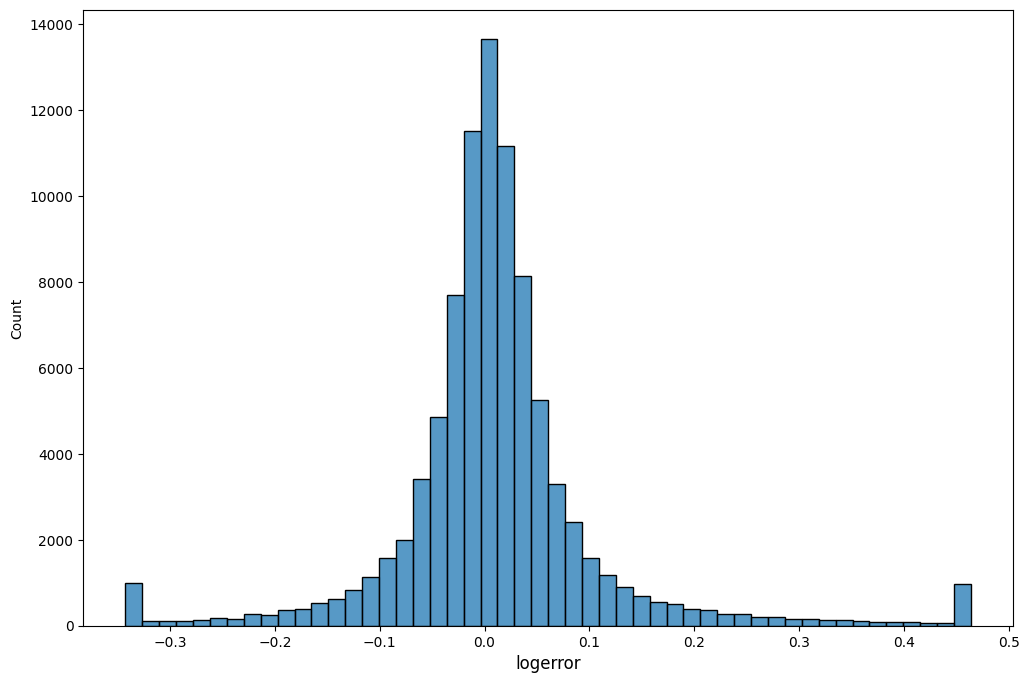

In [74]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
# train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit
# train_df['logerror'].ix[train_df['logerror']<llimit] = llimit
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
# sns.distplot(train_df.logerror.values, bins=50, kde=False)
sns.histplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

로그 오류에 대한 정규 분포가 멋지네요.

**Transaction Date:**

이제 날짜 필드를 살펴보겠습니다. 먼저 각 월의 거래 수를 확인해 보겠습니다.

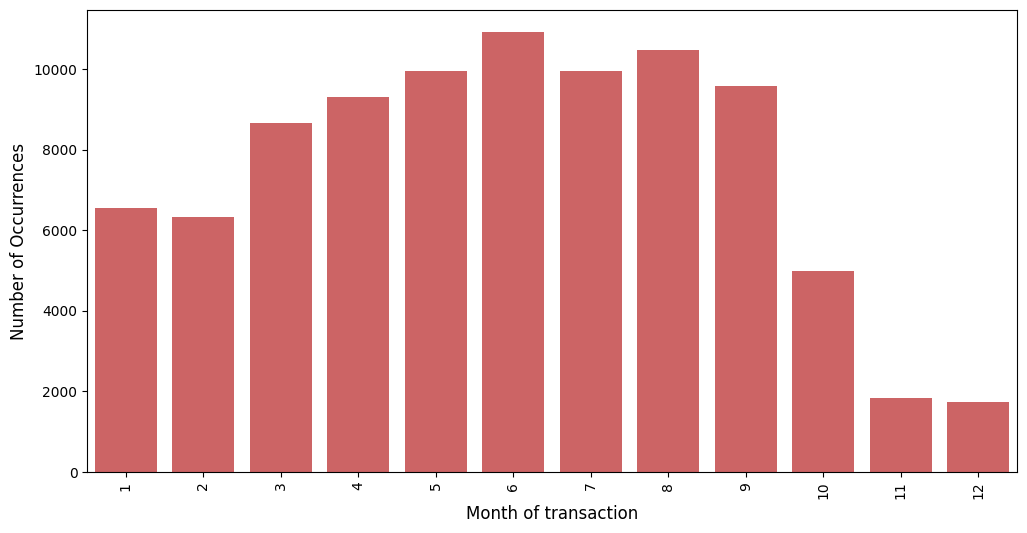

In [75]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
# sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

데이터 페이지에서도 볼 수 있듯이 train 데이터에는 2016년 10월 15일 이전의 모든 거래와 2016년 10월 15일 이후의 일부 거래가 포함되어 있습니다.

따라서 마지막 3개월 동안의 막대가 더 짧습니다.

**Parcel Id:**

In [76]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

따라서 대부분의 parcelid 는 데이터 세트에 한 번만 표시됩니다.

**Properties 2016:**

이제 properties_2016 파일을 살펴보겠습니다

In [77]:
prop_df = pd.read_csv("../input/Zillow Prize: Zillow’s Home Value Prediction/properties_2016.csv")
prop_df.shape

/var/folders/gn/kz32_vqd7_bbr6c0gw2d2wn00000gn/T/ipykernel_93499/113075248.py:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_df = pd.read_csv("../input/Zillow Prize: Zillow’s Home Value Prediction/properties_2016.csv")


(2985217, 58)

In [78]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


데이터 집합에 NaN 값이 너무 많습니다. 먼저 이 값에 대해 몇 가지 탐색을 해보겠습니다.

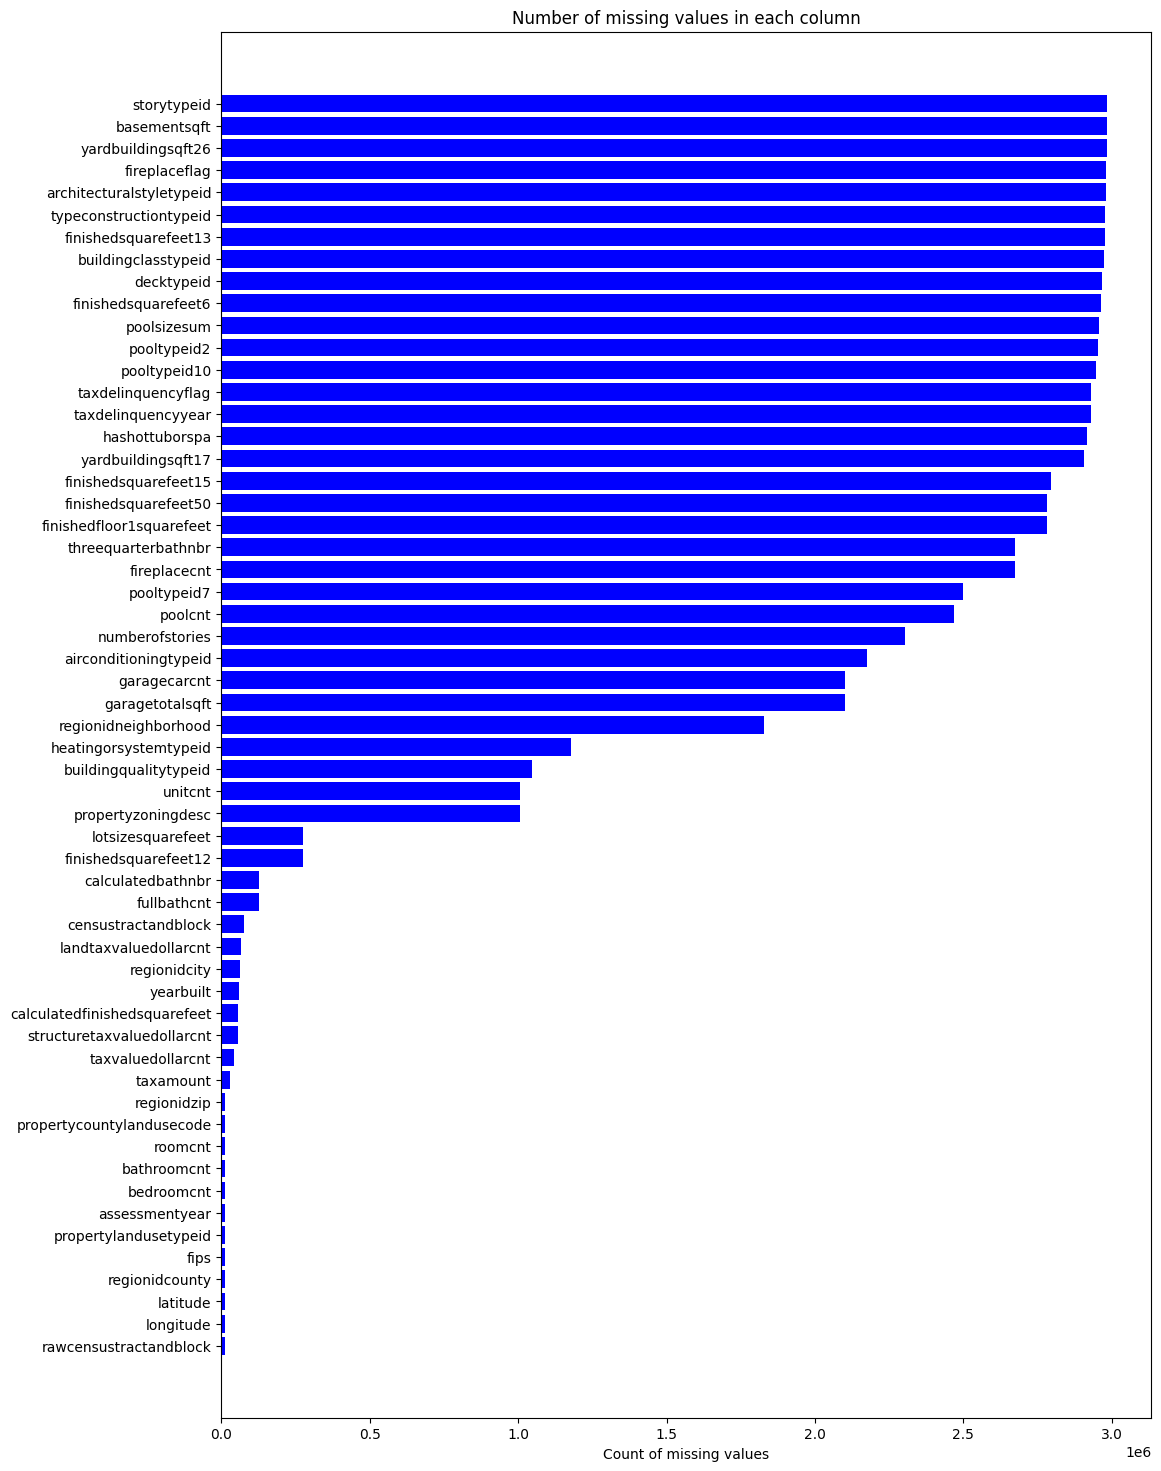

In [79]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
#missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

먼저 위도 및 경도 변수를 살펴보겠습니다.

<Figure size 1200x1200 with 0 Axes>

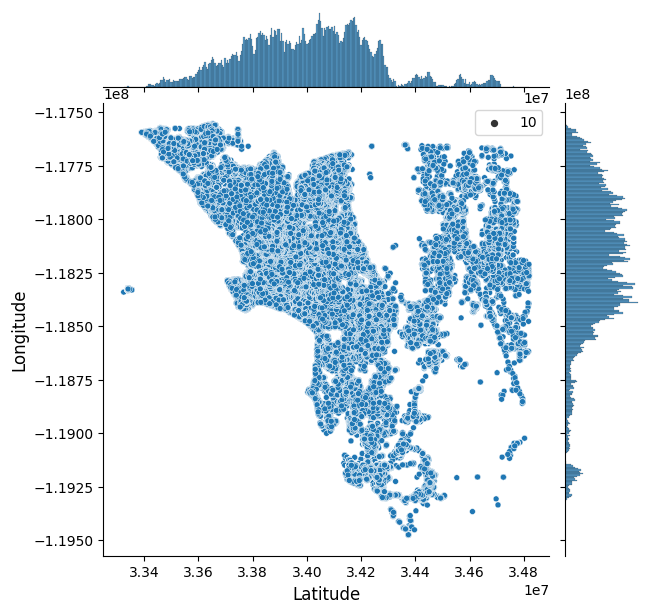

In [80]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

데이터 페이지에서 2016년 3개 카운티(캘리포니아주 로스앤젤레스, 오렌지, 벤투라)의 부동산 전체 목록이 제공됩니다.

열에는 약 90,811개의 행이 있지만 속성 파일에는 약 2,985,217개의 행이 있습니다. 따라서 두 파일을 병합한 다음 분석을 수행하겠습니다.

In [81]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


이제 다양한 유형의 변수에 대해 살펴보겠습니다.

In [82]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


거의 대부분이 객체(범주형) 변수가 거의 없는 실수 변수입니다. 개수를 계산해 봅시다.

In [83]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


이제 병합된 새 데이터 집합의 Null 개수를 확인해 보겠습니다.

In [84]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


4개 열에 99.9%의 확률로 누락된 값이 있습니다!

**Univariate Analysis:** # 단변량 분석?

변수가 너무 많으므로 먼저 'float' 변수만 가져온 다음 대상 변수와의 상관관계를 통해 변수가 어떻게 연관되어 있는지 살펴봅시다.

/var/folders/gn/kz32_vqd7_bbr6c0gw2d2wn00000gn/T/ipykernel_93499/1488330499.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_values = train_df.mean(axis=0)
/var/folders/gn/kz32_vqd7_bbr6c0gw2d2wn00000gn/T/ipykernel_93499/1488330499.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_values = train_df.mean(axis=0)
/Users/digituno/.pyenv/versions/3.10.10/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/digituno/.pyenv/versions/3.10.10/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encounter

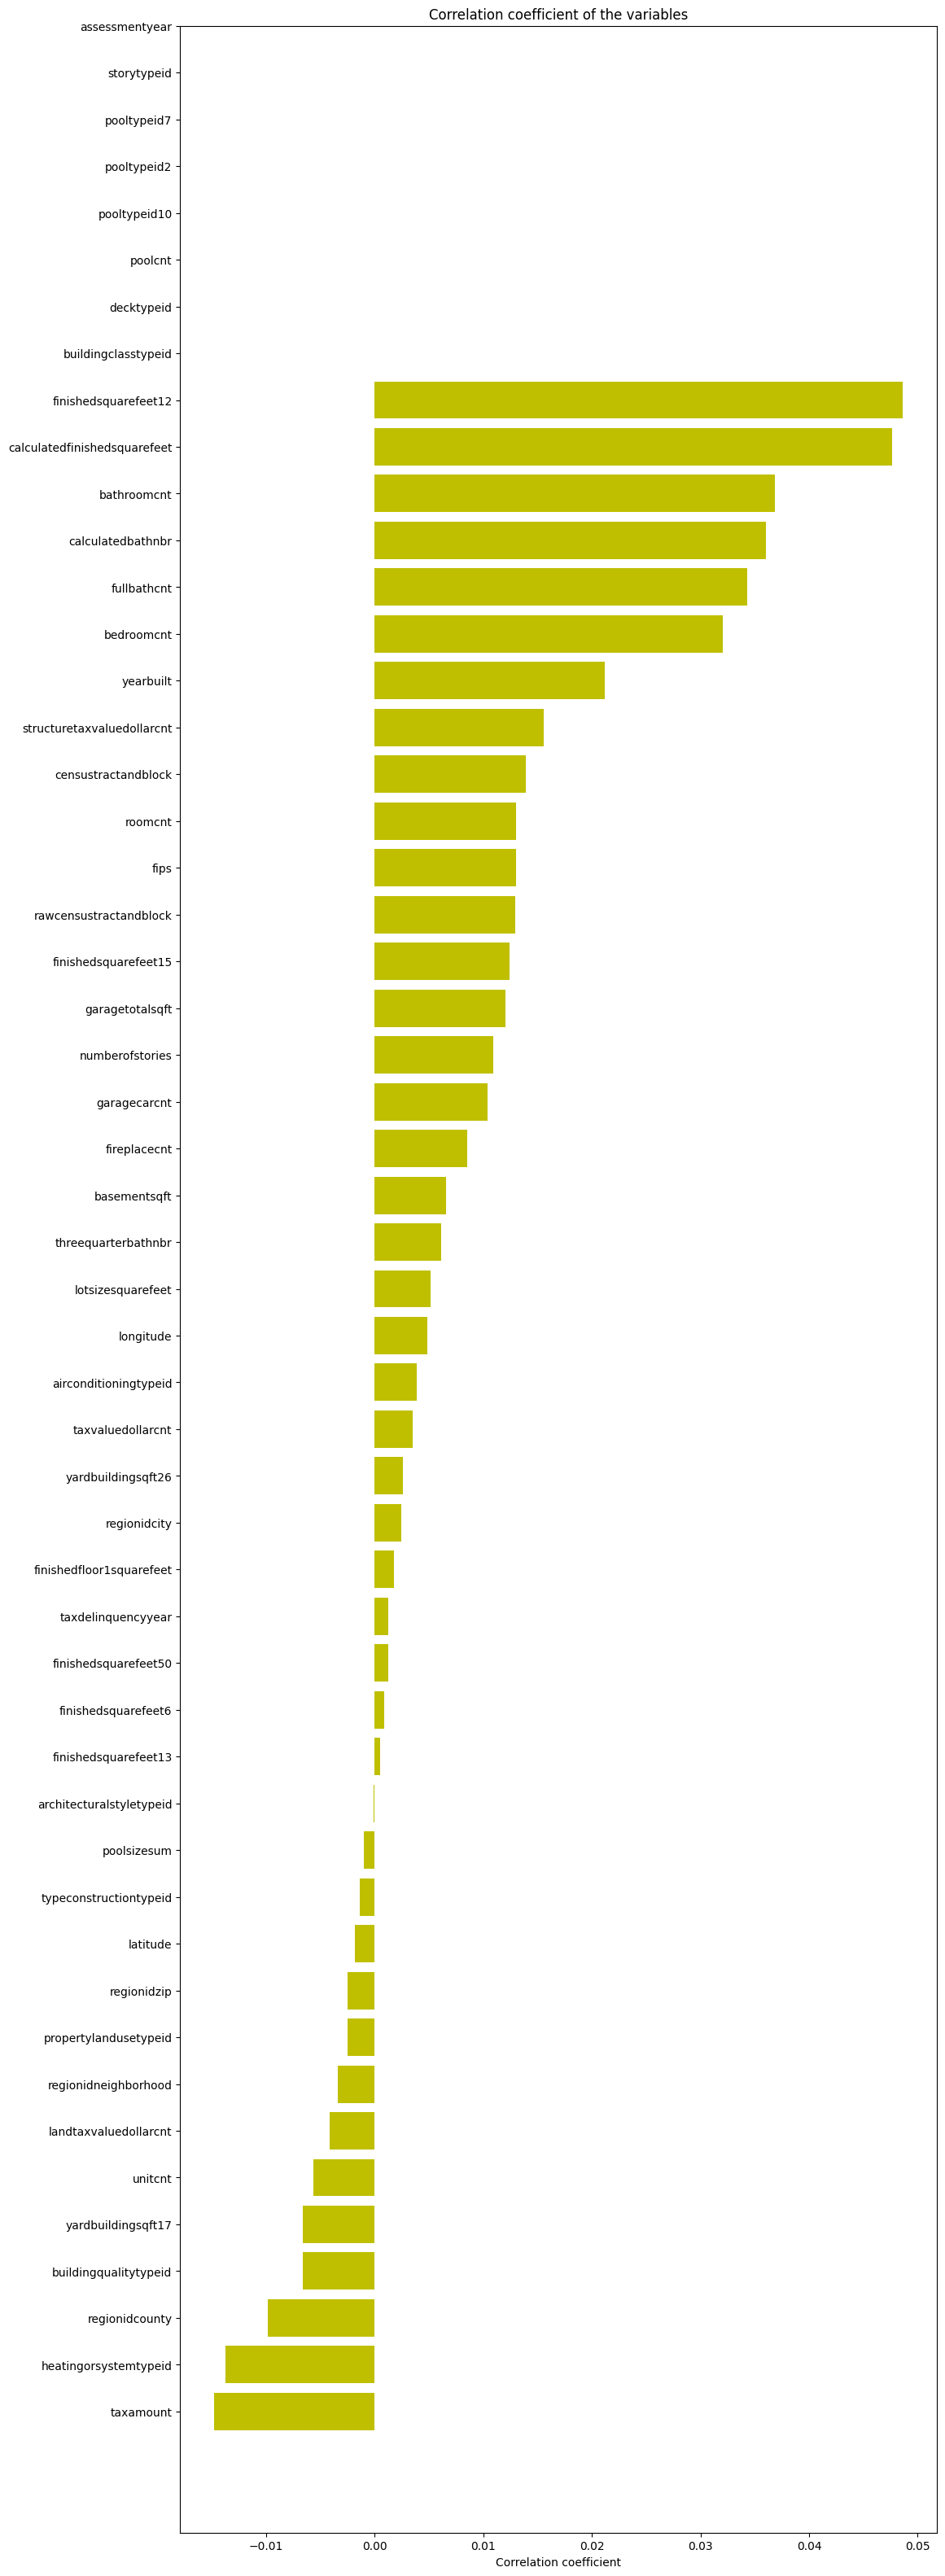

In [85]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)
train_df.fillna(mean_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

대상 변수와 주어진 변수 집합의 상관관계가 전반적으로 낮습니다.

이 그래프의 맨 위에는 상관관계 값이 없는 변수가 거의 없습니다. 고유 값이 하나만 있어서 상관관계 값이 없는 것 같습니다. 마찬가지로 확인해 보겠습니다.

In [86]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


상관관계 값이 높은 변수를 가져와서 몇 가지 분석을 해 보겠습니다.

In [87]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


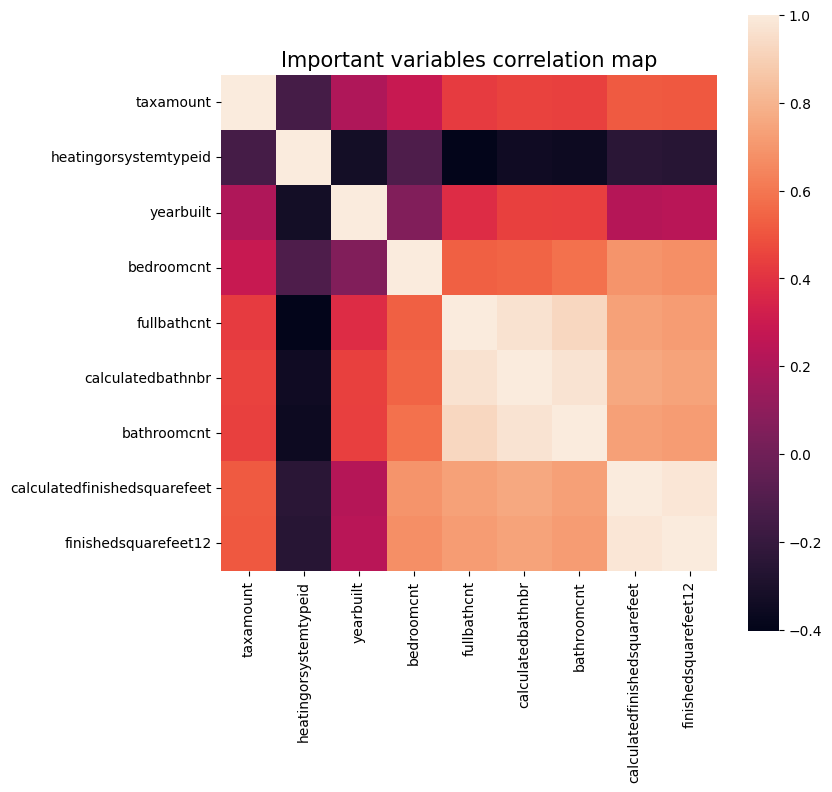

In [88]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

중요한 변수들 자체는 상관관계가 매우 높습니다. 이제 각각의 변수를 살펴보겠습니다.

**Finished SquareFeet 12:**

로그 오류에 따라 완성된 제곱피트 12가 어떻게 달라지는지 살펴보겠습니다.

<Figure size 1200x1200 with 0 Axes>

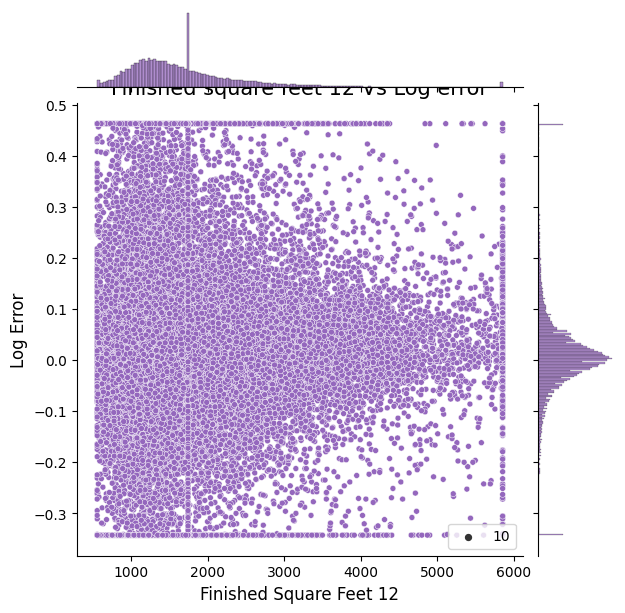

In [89]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

완성된 평방 피트 12 변수가 증가함에 따라 로그 오차의 범위가 좁아지는 것 같습니다. 아마도 큰 집일수록 예측하기 쉬울까요?

**Calculated finished square feet:**

<Figure size 1200x1200 with 0 Axes>

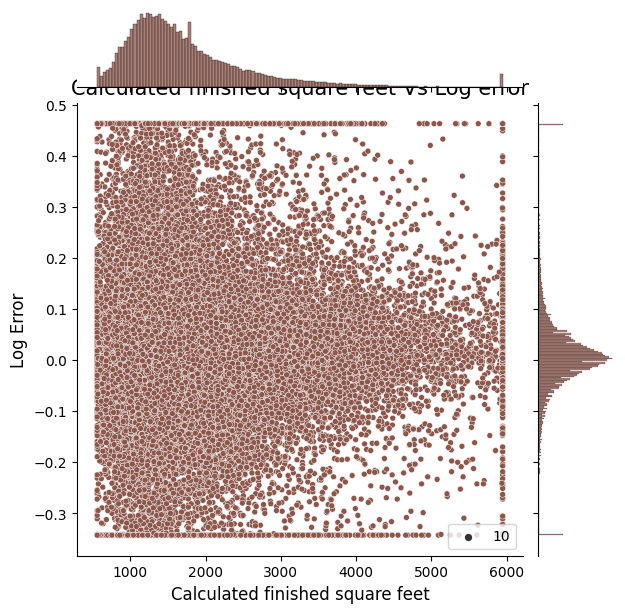

In [90]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

여기에서도 분포는 앞의 분포와 매우 유사합니다. 두 변수 간의 상관관계도 높은 것은 당연합니다.

**Bathroom Count:**

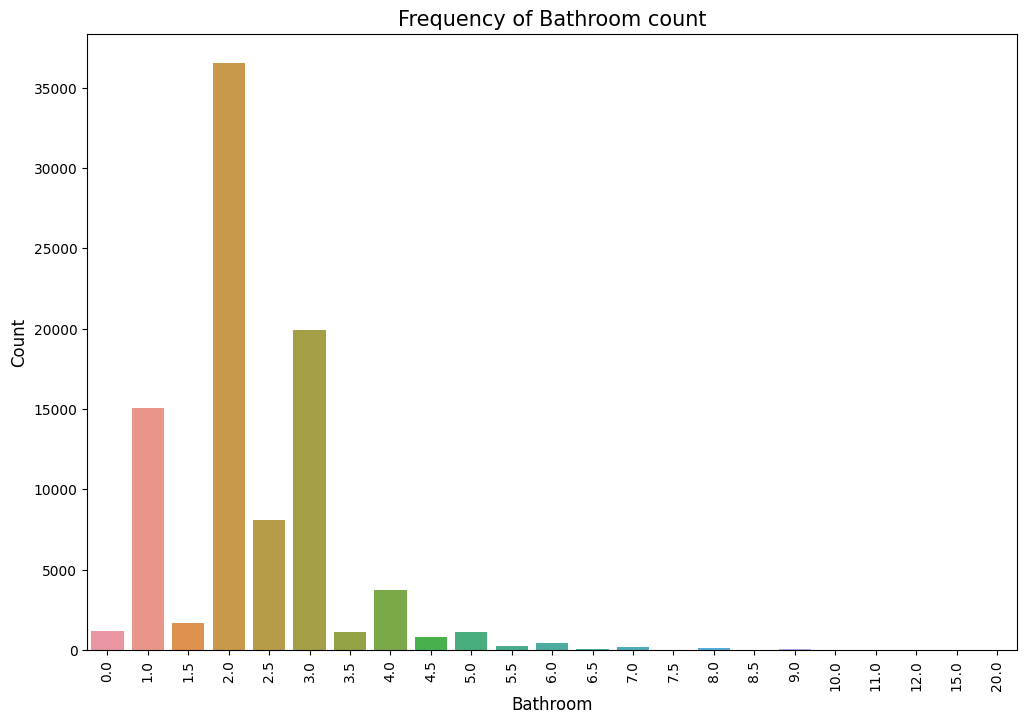

In [91]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

화장실 수에 2.279라는 흥미로운 값이 있습니다. ???

편집: 미화한 님이 댓글에서 지적한 대로 평균값입니다.)

이제 이를 기준으로 로그 에러가 어떻게 변하는지 확인해 보겠습니다. 

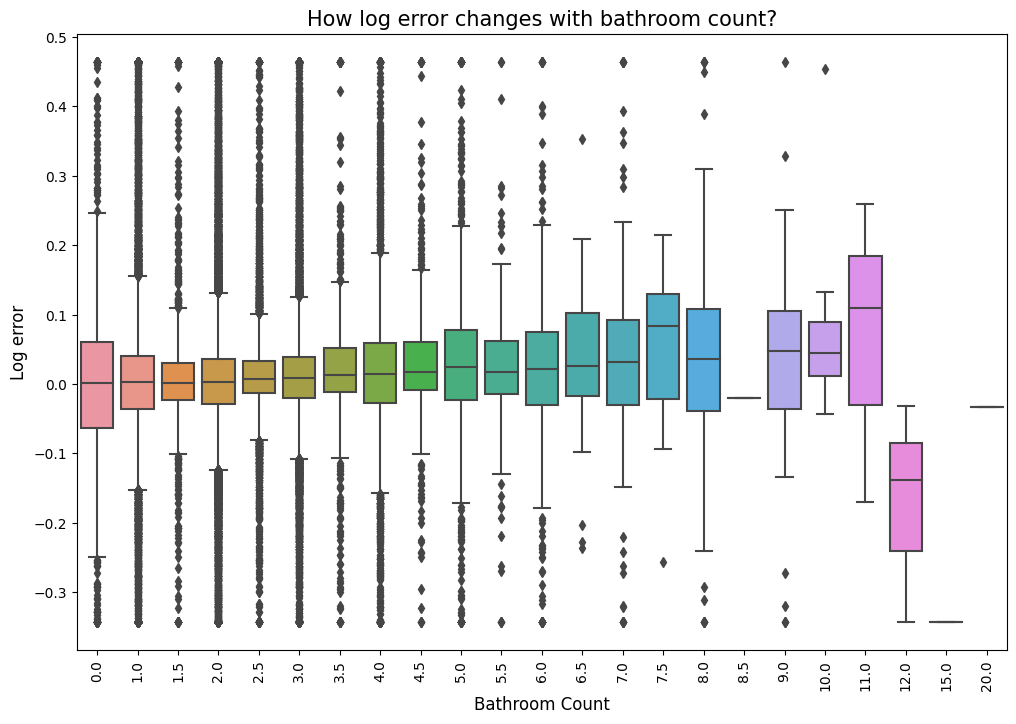

In [92]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

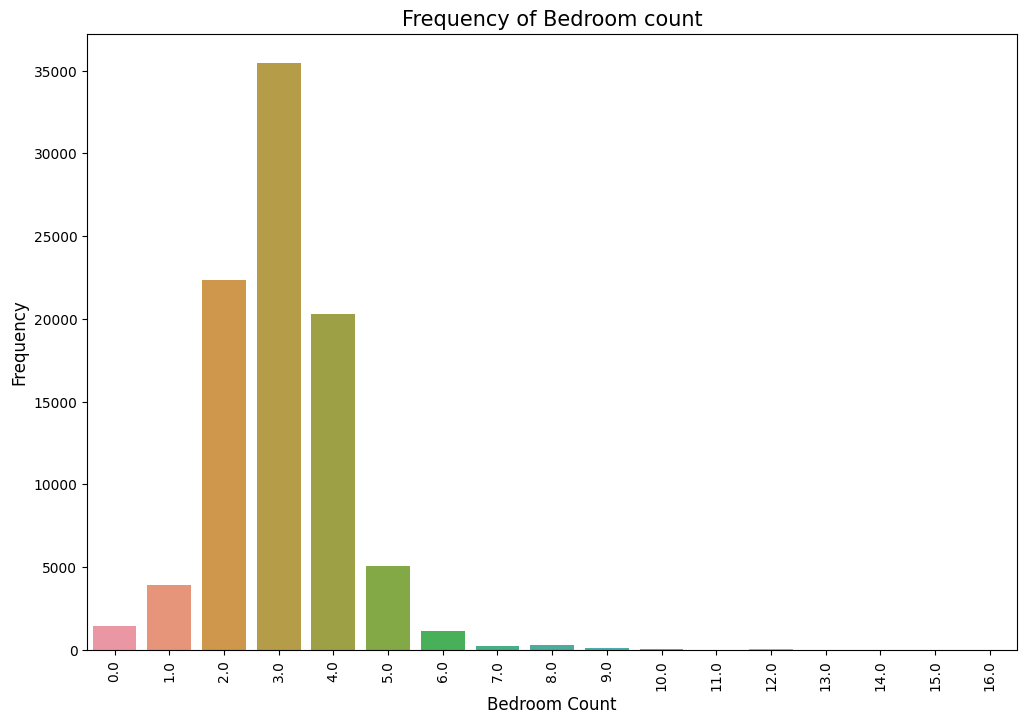

In [93]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

3.03은 Null 값을 대체한 평균값입니다. ??

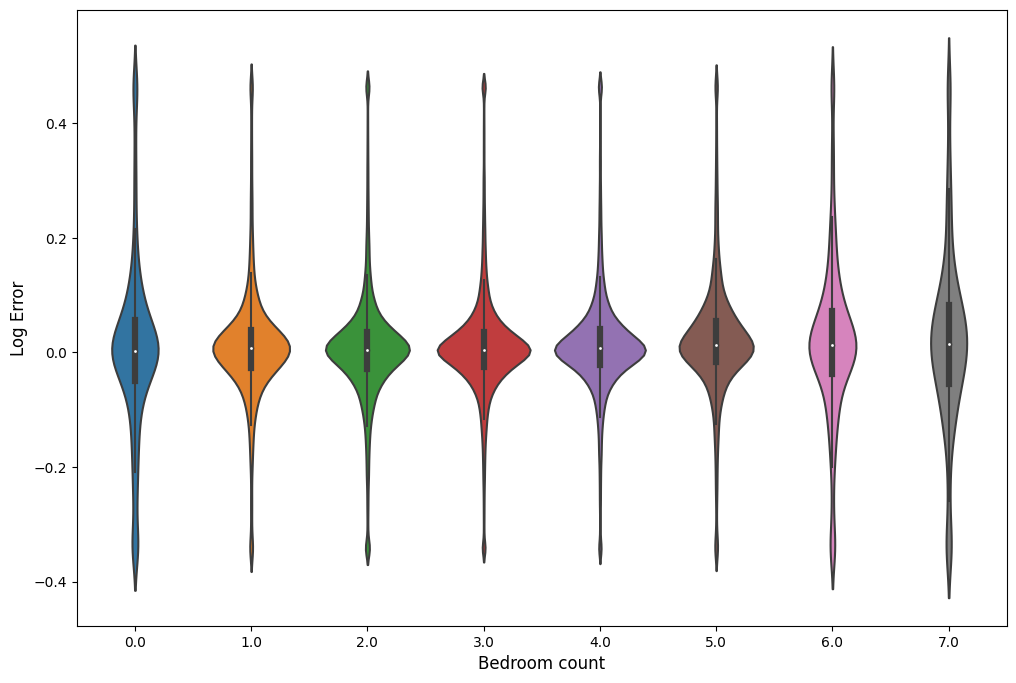

In [94]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

<Figure size 1200x1200 with 0 Axes>

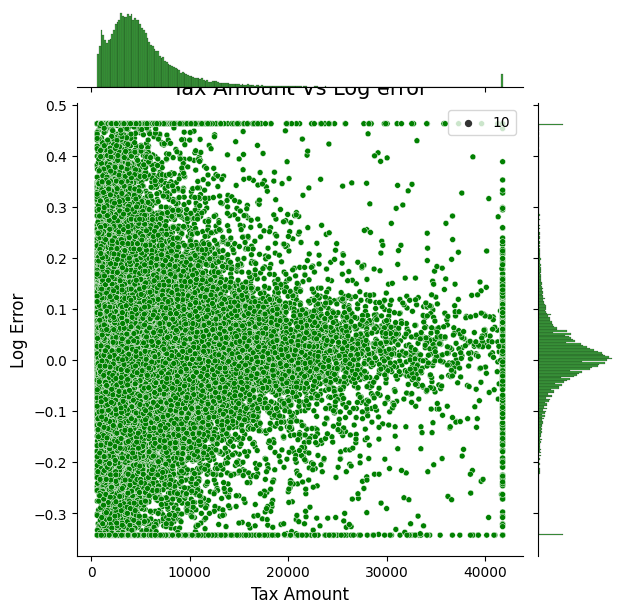

In [95]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**

연도별 변수에 따라 오류가 어떻게 달라지는지 살펴보겠습니다.

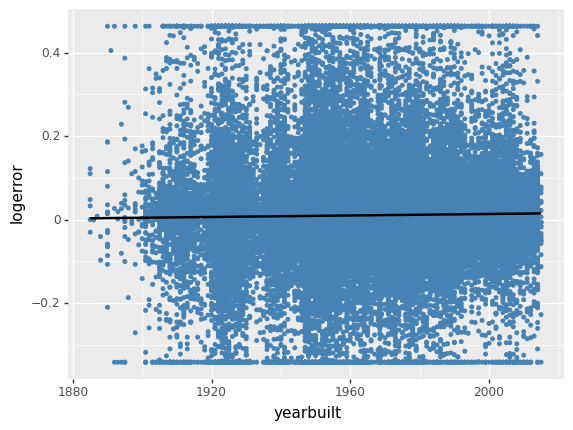

<ggplot: (828213441)>

In [115]:
# from ggplot import *
# ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
#     geom_point(color='steelblue', size=1) + \
#     stat_smooth()
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

(
    ggplot(train_df, aes(x='yearbuilt', y='logerror'))
    + geom_point(color='steelblue', size=1)
    + stat_smooth()
)

구축 연도와 관련하여 약간의 증가 추세를 볼 수 있습니다.

이제 위도와 경도에 따라 로그 오차가 어떻게 달라지는지 살펴보겠습니다.

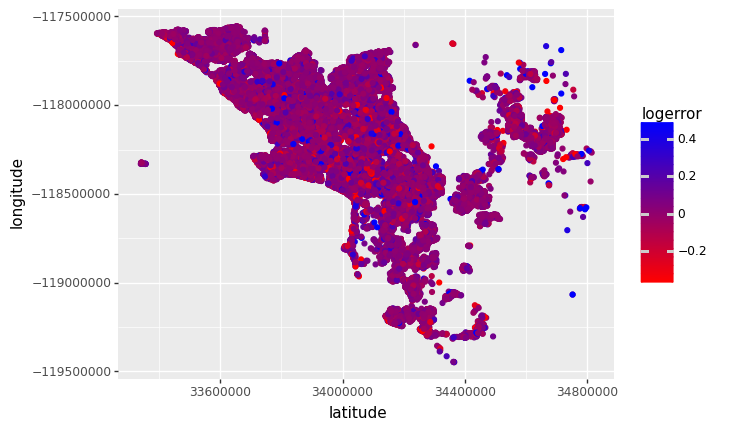

<ggplot: (764735341)>

In [118]:
# ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
#     geom_point() + \
#     scale_color_gradient(low = 'red', high = 'blue')
(
    ggplot(train_df, aes(x='latitude', y='longitude', color='logerror'))
    + geom_point()
    + scale_color_gradient(low = 'red', high = 'blue')
)

적어도 육안으로는 위도나 경도와 관련하여 눈에 보이는 포켓이 없습니다.

양의 상관관계가 가장 높은 변수와 음의 상관관계가 가장 높은 변수를 가져와서 눈에 보이는 패턴이 있는지 살펴봅시다.

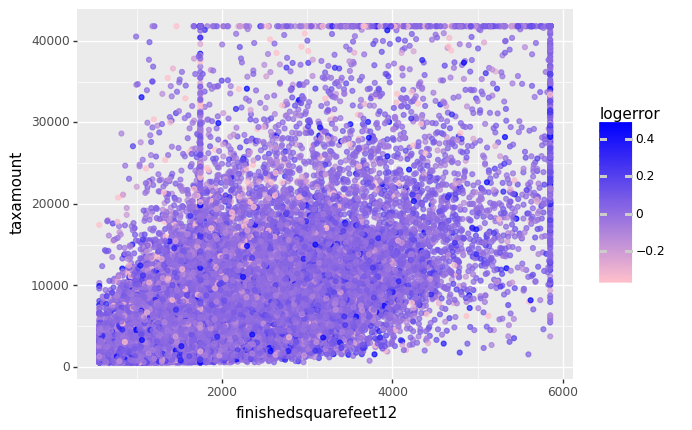

<ggplot: (828010569)>

In [119]:
# ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
#     geom_point(alpha=0.7) + \
#     scale_color_gradient(low = 'pink', high = 'blue')
(
    ggplot(train_df, aes(x='finishedsquarefeet12', y='taxamount', color='logerror'))
    + geom_point(alpha=0.7)
    + scale_color_gradient(low = 'pink', high = 'blue')
)

여기에도 눈에 띄는 패턴이 없습니다. 그래서 예측하기 어려운 경쟁이 될 것 같습니다.

재미로 기계가 임의의 패턴을 만들도록 하겠습니다.

In [121]:
# ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
#     geom_now_its_art()
(
    ggplot(train_df, aes(x='finishedsquarefeet12', y='taxamount', color='logerror'))
    + geom_now_its_art()
)
# Put a bird on it!

만세! 드디어 데이터에서 멋진 패턴을 발견했습니다.

단변량 분석에서 중요한 변수에 대해 이해했습니다. 그러나 이것은 독립적인 기준이며 선형성 가정도 있습니다. 이제 추가 트리 모델을 구축하여 중요한 변수를 얻기 위해 비선형 모델을 구축해 보겠습니다.

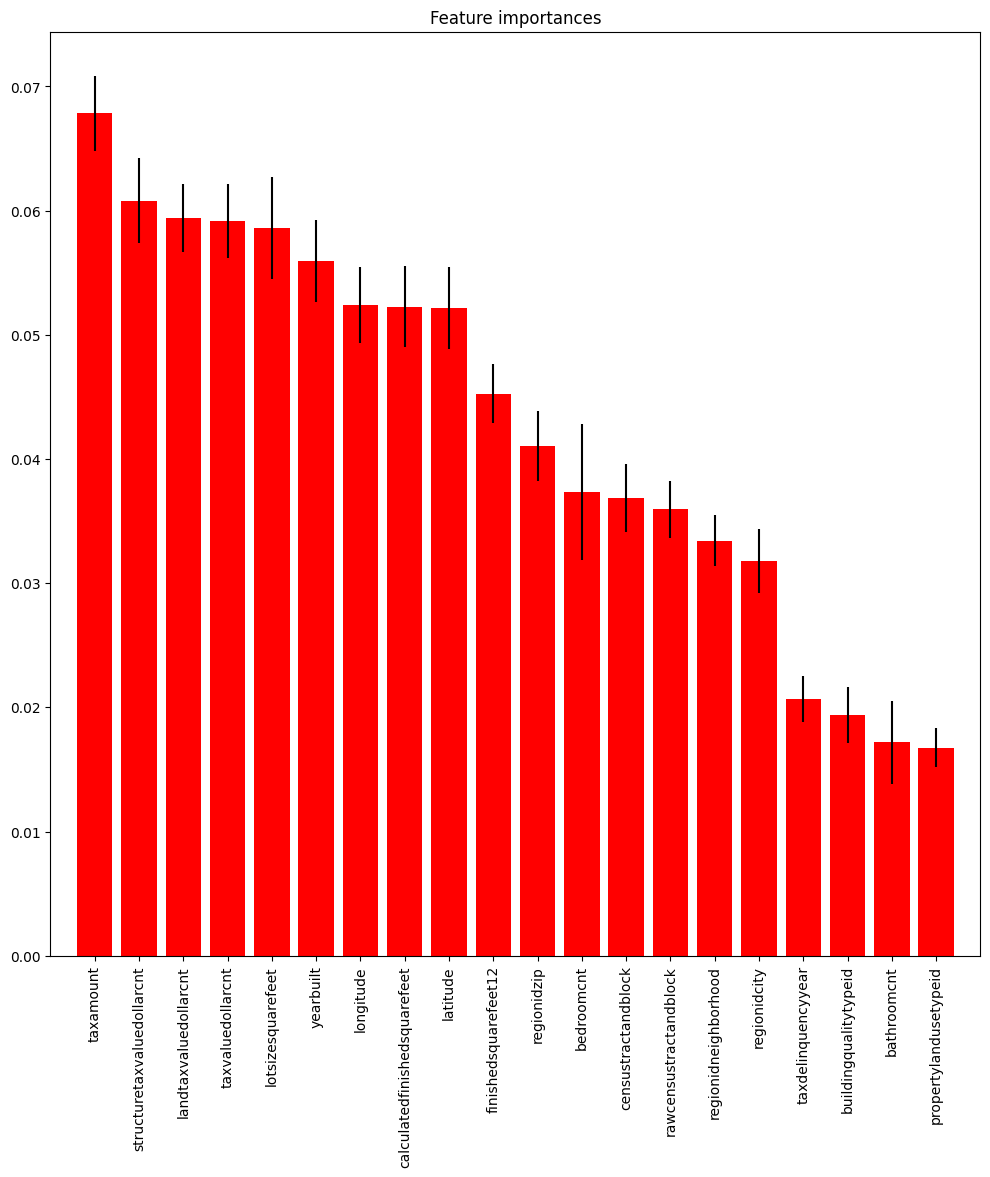

In [123]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

'tax amount'이 가장 중요한 변수이고 그 다음이 'structure tax value dollar count'와 'land tax value dollor count'인 것 같습니다.

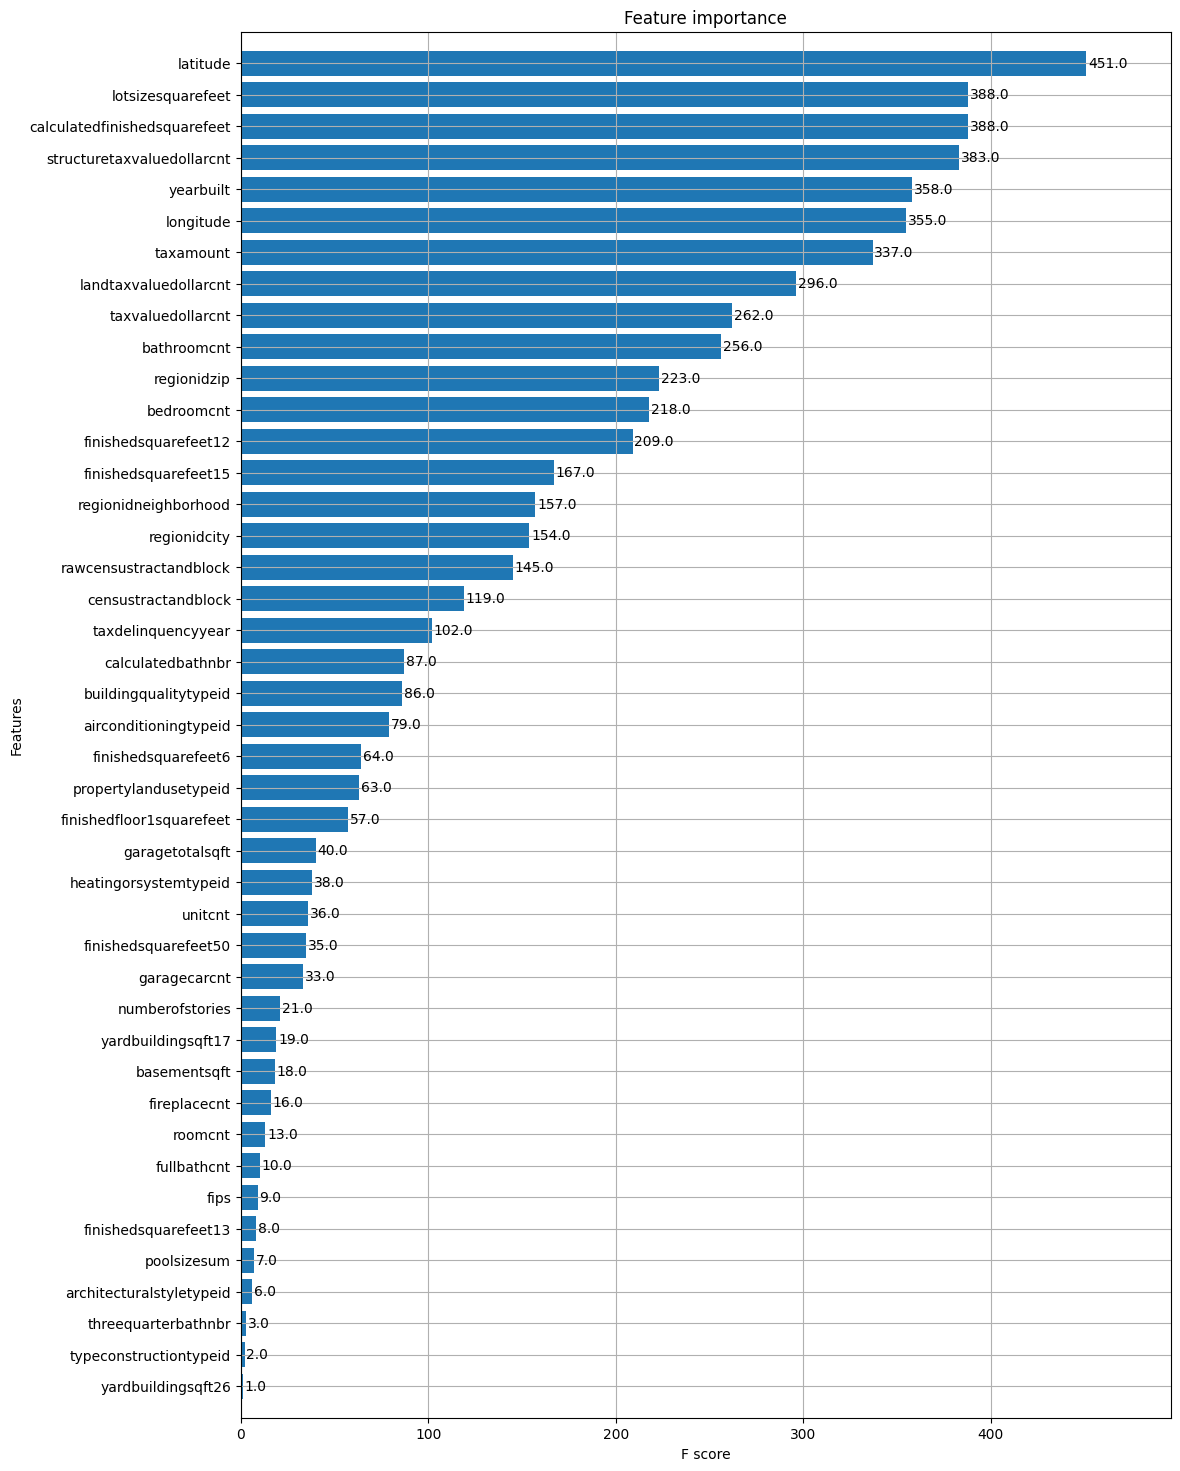

In [127]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'verbosity': 0,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

xgboost를 사용하는 경우 중요한 변수는 'structured tax value dollar count'와 'latitude' 및 'calculated finished square feet'입니다.